<a href="https://colab.research.google.com/github/VidyaDaya/my-projects/blob/master/FASHION_MNIST_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective

Demonstrate the knowledge in deep learning that you have acquired from the lectures and practical lab materials.
We work with Fashion-MNIST dataset for image recognition. The dataset contains 10 classes of 28x28 grayscale images. 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

print(tf.__version__)
print(keras.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.2.0-rc3
2.3.0-tf
Num GPUs Available:  1


## Task 1 Load the data



Load the Fashion MNIST dataset (https://github.com/zalandoresearch/fashion-mnist). You may get the data via Keras (keras.datasets) or Tensorflow Datasets (tfds). 

In [ ]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Using TensorFlow backend.


In [ ]:
x_train.shape

(60000, 28, 28)

## Task 2 Understand the data





Display 100 images from the train set in the form of 10x10 matrix.

Answer the following questions:

1. What are the unique labels in this dataset?
2. How many training images and how many test images?
3. What is the size of each image?
4. Find out the numeric range of the input. Do we need to rescale the input?
5. In our problem, what are the shapes of input tensors and target tensors? Do you need to reshape the input?


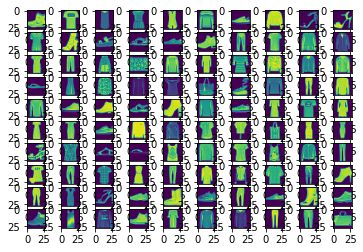

In [ ]:
image_index = 0 
f, axarr = plt.subplots(10,10)
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(x_train[image_index])
        image_index+=1

In [ ]:
print('Unique labels in dataset')
u = np.unique(y_train)
print(u)

Unique labels in dataset
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
print("Number of training images")
print(x_train.shape[0])
print("Number of testing images")
print(x_test.shape[0])

Number of training images
60000
Number of testing images
10000


In [ ]:
print("Size of each image")
print(x_train.shape[1]*x_train.shape[2])

Size of each image
784


In [ ]:
val_range= x_train.ptp()
print("Numeric range of the input is till ", val_range)
print("We need to normalize the input and bring down its value between 0 and 1")

Numeric range of the input is till  255
We need to normalize the input and bring down its value between 0 and 1


In [ ]:
print("Input tensor shape is ",x_train.shape)
print("Taget tensor shape is  ",y_train.shape)

Input tensor shape is  (60000, 28, 28)
Taget tensor shape is   (60000,)


We don't need to reshape the input and target tensors.


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Task 3 Construct an input pipeline



Creat train/validate/test data splits and construct tf.data pipelines. Make sure that the training data is batched.


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((x_train,y_train))
for image,label in train_dataset.take(1):
  print(image.shape,label.shape) 

(28, 28) (10,)


In [ ]:
def preprocess(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = image / 255
  return image, label


In [ ]:
train_dataset = (train_dataset.map(preprocess).shuffle(buffer_size=50000).batch(128,drop_remainder=True).cache().repeat())

In [ ]:
test_dataset=(test_dataset.map(preprocess).batch(128,drop_remainder=True).cache().repeat())

## Task 4 Construct a deep forward neural network


### Task 4.1 Setting up a model for training

Construct a deep feedforward neural network. You need to decide and report the following configurations:

- Output layer: 
    - How many output nodes?
    - Which activation function?
- Hidden layers:
    - How many hidden layers?
    - How many nodes in each layer?
    - Which activation function for each layer?
- Input layer
    - What is the input size?
- The loss function
- The metrics for model evaluation (which may be different from the loss function)
- The optimiser

Justify your model design decisions.

Plot the model structure `using keras.utils.plot_model` or similar tools.

Output layer:
We are having 10 output nodes and we are using softmax activation function for the output layer.
Hidden layers:
We have 2 hidden layers for our model and each layer has 128 nodes. For both the hidden layers, we have relu as the activation function.
Input layer:
The input size is (28,28) as mentioned in the model.
For the model, we also use categorical crossentropy as the loss function, accuracy as the metric and adam as the optimizer.

In [ ]:
from tensorflow.keras.optimizers import Adam
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))
model.compile(optimizer = Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=["accuracy"])

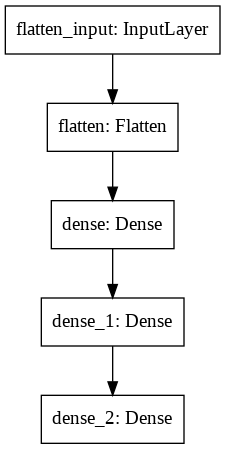

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


### Task 4.2 Fitting the model

Now fit the model. Decide and report the following training setting:

1. The training batch size
2. The number of training epochs (at least 1,000 epochs recommended)
3. The learning rate. If you used momentum or a learning rate schedule, please report the configuration as well.

Plot the training and validation loss and accuracy. Answer the following questions:

1. Do you see overfitting or underfitting? Why?
2. If you see overfitting, at which epoch did it happen?

In [ ]:
from datetime import datetime
import os
root_logdir="logs"
run_id=datetime.now().strftime("%Y%m%d-%H%M%S")
logdir=os.path.join(root_logdir,run_id)
tf.compat.v1.reset_default_graph()

In [ ]:
!rm -rf ./logs/
file_writer=tf.summary.create_file_writer(logdir)

In [ ]:
keras.callbacks.TensorBoard(
  log_dir=logdir,
  histogram_freq=1,  # How often to log histogram visualizations
  embeddings_freq=0,  # How often to log embedding visualizations
  update_freq='batch')  # How often to write logs (default: once per epoch)

The batch size we are using is 128. We are going to fit the model over 1000 epochs. For the optimizer- Adam we use a learning rate of 0.01.

In [ ]:
BATCH_SIZE=128
EPOCHS=1000
STEPS_PER_EPOCH=100
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir=logdir)
history=model.fit(train_dataset,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=test_dataset,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=50,verbose=1,shuffle=True,callbacks=[tensorboard_cbk])


Epoch 1/1000
100/100 [==============================] - 1s 14ms/step - loss: 1.1581 - accuracy: 0.5583 - val_loss: 0.7754 - val_accuracy: 0.7059
Epoch 2/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.6701 - accuracy: 0.7479 - val_loss: 0.6446 - val_accuracy: 0.7623
Epoch 3/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.5761 - accuracy: 0.7889 - val_loss: 0.5692 - val_accuracy: 0.7970
Epoch 4/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.5477 - accuracy: 0.8005 - val_loss: 0.5536 - val_accuracy: 0.8031
Epoch 5/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.4996 - accuracy: 0.8184 - val_loss: 0.5264 - val_accuracy: 0.8127
Epoch 6/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.4935 - accuracy: 0.8219 - val_loss: 0.5298 - val_accuracy: 0.8091
Epoch 7/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.4538 - accuracy: 0.8322 - val_loss: 0.4875 - val_accuracy

In [ ]:
loss_value,acc_value=model.evaluate(test_dataset,steps=50,verbose=0)
print("Accuracy of our model is ", acc_value)

Accuracy of our model is  0.8656250238418579


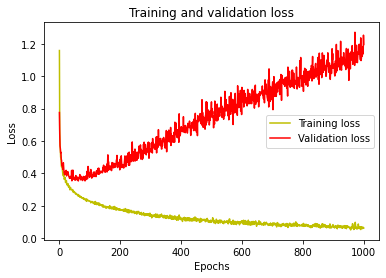

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

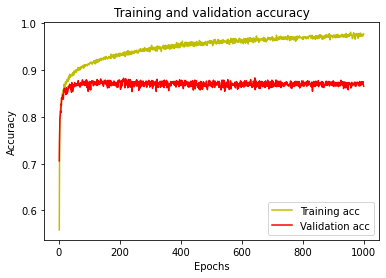

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the above two plots, we can clearly see that there is overfitting in our model. From the training and validation loss plot, we can see that the validation loss decreases with training loss till about 200 epochs and then continues to increase.
Similarly, for the training and validation accuracy plot, we can see that theaccuracy of the validation set doesn't increase with the training accuracy after 200 epochs.

## Task 5 Fine-tuning the model


You may see above that your model is overfitting. There are multiple things you can do. Below are some options:

1. Add dropout
2. Add Batch Normalisation
3. Add layer-specific weight regularizations
4. Change the learning rate

Apply different regularisation techniques to the model training. You may also try other techniques for improving training such as learning rate scheduling (see https://www.tensorflow.org/guide/keras/train_and_evaluate#using_learning_rate_schedules).

Run **five or more** experiments of different training configurations and record the test accuracy achieved in the Markdown table below. You may modify the table heading to match your experiment design.


In [ ]:
model_dropout = keras.Sequential()
model_dropout.add(keras.layers.Flatten(input_shape=(28, 28)))
model_dropout.add(keras.layers.Dense(128, activation='relu'))
model_dropout.add(keras.layers.Dropout(0.5))
model_dropout.add(keras.layers.Dense(128, activation='relu'))
model_dropout.add(keras.layers.Dropout(0.5))
model_dropout.add(keras.layers.Dense(10,activation='softmax'))
model_dropout.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=["accuracy"])

In [ ]:
model_dropout.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
__________________________________________________

In [ ]:
history_dropout = model_dropout.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=50,validation_data=test_dataset,batch_size=BATCH_SIZE,verbose = 1,shuffle=True)

Epoch 1/1000
100/100 [==============================] - 1s 8ms/step - loss: 2.0930 - accuracy: 0.2570 - val_loss: 1.6601 - val_accuracy: 0.4923
Epoch 2/1000
100/100 [==============================] - 1s 7ms/step - loss: 1.4678 - accuracy: 0.4116 - val_loss: 1.1948 - val_accuracy: 0.5359
Epoch 3/1000
100/100 [==============================] - 1s 8ms/step - loss: 1.1963 - accuracy: 0.5216 - val_loss: 1.0193 - val_accuracy: 0.5983
Epoch 4/1000
100/100 [==============================] - 1s 8ms/step - loss: 1.0817 - accuracy: 0.5681 - val_loss: 0.9221 - val_accuracy: 0.6909
Epoch 5/1000
100/100 [==============================] - 1s 7ms/step - loss: 1.0001 - accuracy: 0.6106 - val_loss: 0.8500 - val_accuracy: 0.6986
Epoch 6/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.9380 - accuracy: 0.6439 - val_loss: 0.7984 - val_accuracy: 0.7275
Epoch 7/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.8899 - accuracy: 0.6729 - val_loss: 0.7533 - val_accuracy:

In [ ]:
dropout_loss,dropout_acc=model_dropout.evaluate(test_dataset,steps=50)
print("Accuracy with dropout layers is ",dropout_acc)

50/50 [==============================] - 0s 8ms/step - loss: 0.3700 - accuracy: 0.8773
Accuracy with dropout layers is  0.8773437738418579


In [ ]:
batch_model = tf.keras.Sequential()
batch_model.add(keras.layers.Flatten(input_shape=(28, 28)))
batch_model.add(keras.layers.Dense(128, activation='relu'))
batch_model.add(keras.layers.BatchNormalization())
batch_model.add(keras.layers.Dense(128, activation='relu')) 
batch_model.add(keras.layers.BatchNormalization())                     
batch_model.add(keras.layers.Dense(10,activation='softmax'))                            

batch_model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=["accuracy"])

In [ ]:
history_batch = batch_model.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=50,validation_data=test_dataset,batch_size=BATCH_SIZE,verbose = 1,shuffle=True)

Epoch 1/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.6730 - accuracy: 0.7641 - val_loss: 2.2814 - val_accuracy: 0.0984
Epoch 2/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.4690 - accuracy: 0.8320 - val_loss: 2.2486 - val_accuracy: 0.0984
Epoch 3/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.4321 - accuracy: 0.8445 - val_loss: 2.1407 - val_accuracy: 0.1619
Epoch 4/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.4114 - accuracy: 0.8534 - val_loss: 1.8248 - val_accuracy: 0.2778
Epoch 5/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.3931 - accuracy: 0.8562 - val_loss: 1.2136 - val_accuracy: 0.7061
Epoch 6/1000
100/100 [==============================] - 1s 9ms/step - loss: 0.3803 - accuracy: 0.8612 - val_loss: 0.7143 - val_accuracy: 0.8105
Epoch 7/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.3594 - accuracy: 0.8712 - val_loss: 0.5026 - val_accuracy:

In [ ]:
batch_loss,batch_acc=batch_model.evaluate(test_dataset,steps=50)
print("Accuracy with batch normalization is ",batch_acc)

50/50 [==============================] - 0s 8ms/step - loss: 1.7072 - accuracy: 0.8405
Accuracy with batch normalization is  0.8404687643051147


In [ ]:
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

adam_lr = keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(optimizer=adam_lr,loss="categorical_crossentropy",metrics="accuracy")

In [ ]:
history_lr=model.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=50,validation_data=test_dataset,batch_size=BATCH_SIZE,verbose = 1,shuffle=True)

Epoch 1/1000
100/100 [==============================] - 1s 8ms/step - loss: 0.0891 - accuracy: 0.9709 - val_loss: 1.0970 - val_accuracy: 0.8737
Epoch 2/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0590 - accuracy: 0.9764 - val_loss: 1.2035 - val_accuracy: 0.8728
Epoch 3/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0658 - accuracy: 0.9756 - val_loss: 1.1103 - val_accuracy: 0.8747
Epoch 4/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0756 - accuracy: 0.9717 - val_loss: 1.1951 - val_accuracy: 0.8664
Epoch 5/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0606 - accuracy: 0.9773 - val_loss: 1.1611 - val_accuracy: 0.8686
Epoch 6/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0579 - accuracy: 0.9756 - val_loss: 1.1680 - val_accuracy: 0.8669
Epoch 7/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.0531 - accuracy: 0.9798 - val_loss: 1.2504 - val_accuracy:

In [ ]:
model_lr_loss,model_lr_acc=model.evaluate(test_dataset,steps=50)
print("Accuracy with Initial learning rate of 0.01 is ", model_lr_acc)

50/50 [==============================] - 0s 8ms/step - loss: 1.7999 - accuracy: 0.8723
Accuracy with Initial learning rate of 0.01 is  0.8723437786102295


In [ ]:
NO_EPOCHS=250
history_lr_250epoch=model.fit(train_dataset,epochs=NO_EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=50,validation_data=test_dataset,batch_size=BATCH_SIZE,verbose = 1,shuffle=True)

Epoch 1/250
100/100 [==============================] - 1s 7ms/step - loss: 0.0610 - accuracy: 0.9812 - val_loss: 1.7831 - val_accuracy: 0.8745
Epoch 2/250
100/100 [==============================] - 1s 7ms/step - loss: 0.0312 - accuracy: 0.9882 - val_loss: 1.7730 - val_accuracy: 0.8747
Epoch 3/250
100/100 [==============================] - 1s 7ms/step - loss: 0.0245 - accuracy: 0.9913 - val_loss: 1.7845 - val_accuracy: 0.8720
Epoch 4/250
100/100 [==============================] - 1s 7ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 1.8600 - val_accuracy: 0.8675
Epoch 5/250
100/100 [==============================] - 1s 7ms/step - loss: 0.0439 - accuracy: 0.9860 - val_loss: 1.7392 - val_accuracy: 0.8766
Epoch 6/250
100/100 [==============================] - 1s 7ms/step - loss: 0.0436 - accuracy: 0.9849 - val_loss: 1.7993 - val_accuracy: 0.8759
Epoch 7/250
100/100 [==============================] - 1s 7ms/step - loss: 0.0378 - accuracy: 0.9866 - val_loss: 1.8754 - val_accuracy: 0.8694

In [ ]:
lr_epoch_loss,lr_epoch_acc=model.evaluate(test_dataset,steps=50)
print("Accuracy with initial Learning rate 0.01 and 250 epochs is ",lr_epoch_acc)

50/50 [==============================] - 0s 8ms/step - loss: 1.8951 - accuracy: 0.8712
Accuracy with initial Learning rate 0.01 and 250 epochs is  0.8712499737739563


In [ ]:
from tensorflow.keras.regularizers import l2
reg_model = keras.Sequential()
reg_model.add(keras.layers.Flatten(input_shape=(28, 28)))
reg_model.add(keras.layers.Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation='relu'))
reg_model.add(keras.layers.Dense(128,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
reg_model.add(keras.layers.Dense(10,activation='softmax'))
reg_model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=["accuracy"])

In [ ]:
NO_EPOCHS=250
history_reg_model=reg_model.fit(train_dataset,epochs=NO_EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=50,validation_data=test_dataset,batch_size=BATCH_SIZE,verbose = 1,shuffle=True)

Epoch 1/250
100/100 [==============================] - 1s 9ms/step - loss: 2.7008 - accuracy: 0.1015 - val_loss: 2.3942 - val_accuracy: 0.1005
Epoch 2/250
100/100 [==============================] - 1s 7ms/step - loss: 2.3412 - accuracy: 0.1023 - val_loss: 2.3133 - val_accuracy: 0.0984
Epoch 3/250
100/100 [==============================] - 1s 7ms/step - loss: 2.3068 - accuracy: 0.0979 - val_loss: 2.3035 - val_accuracy: 0.1005
Epoch 4/250
100/100 [==============================] - 1s 7ms/step - loss: 2.3031 - accuracy: 0.0970 - val_loss: 2.3027 - val_accuracy: 0.1016
Epoch 5/250
100/100 [==============================] - 1s 7ms/step - loss: 2.3028 - accuracy: 0.0982 - val_loss: 2.3027 - val_accuracy: 0.0975
Epoch 6/250
100/100 [==============================] - 1s 7ms/step - loss: 2.3027 - accuracy: 0.0916 - val_loss: 2.3027 - val_accuracy: 0.0980
Epoch 7/250
100/100 [==============================] - 1s 7ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3027 - val_accuracy: 0.0984

In [ ]:
reg_epoch_loss,reg_epoch_acc=model.evaluate(test_dataset,steps=50)
print("Accuracy with l2 regularization is ",reg_epoch_acc)

50/50 [==============================] - 0s 8ms/step - loss: 1.8951 - accuracy: 0.8712
Accuracy with l2 regularization is  0.8712499737739563



|Dropout (rate)   | Batch Normalisation (Y/N)  | Optimiser  | Learning Rate  | Number of Epochs   |     Regularization |  Test Accuracy |
|---|---|---|---|---|---|---|
|   0.5|   |   |   |   |    |   87.7|
|   |   Y  |   |   |   |     |84.0 |
|   |   |   | 0.01(with decay)  |   |    |87.2  |
|   |   |   |   0.01(with decay)    | 250   |     |  87.1  |
|   |   |   |       |  250  |    l2    | 87.1   |



Answer the following questions:

1. Which configuration achieved the best test accuracy?
2. Which setting had the most impact and which one had the least impact?

1. The best configuration was achieved by the addition of a Dropout layer.
2. Considering a layer with l2 regularization has the least impact on the dataset as the results are almost the same as it was in our first model.
Having batch-normalization has the most impact even though the impact has been negative in this scenario as the accuracy has dropped from 87 to 84.